In [28]:
# Standard PyTorch + Torchvision stack
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt


# Reproducibility (essential for research and debugging)
import random
SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Note: For complete reproducibility, you may also need:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Device (GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Let's examine a fresh ResNet-18 pretrained on ImageNet
res18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


## 3) Why Transfer Learning? The Power of Pretrained Features

### The Transfer Learning Hypothesis

Networks trained on large datasets (like ImageNet with 1.2M images, 1000 classes) learn hierarchical features:

Early layers (conv1, layer1): Low-level features (edges, textures, colors)

Middle layers (layer2, layer3): Mid-level features (shapes, parts, patterns)

Deep layers (layer4): High-level, task-specific features (object parts)

Final layer (fc): Class-specific decision boundaries

Key Insight: Low and mid-level features are universal across vision tasks! We can reuse them and only adapt the high-level features to our new task.

## Fine-Tuning Strategies

### 1) Feature Extraction *(Freeze all, train head)*
- **Pros:** Fastest; lowest overfitting risk  
- **Use when:** Limited data; domain ≈ ImageNet  
- **Unfrozen:** `fc` only

---

### 2) Shallow Fine-Tuning *(Unfreeze layer4 + head)*
- **Pros:** Adapts high-level features; still efficient  
- **Use when:** Moderate data; somewhat different domain  
- **Unfrozen:** `layer4`, `fc`

---

### 3) Deep Fine-Tuning *(Unfreeze layer3 + layer4 + head)*
- **Pros:** Greater adaptation capacity  
- **Use when:** Sufficient data; noticeable domain shift  
- **Unfrozen:** `layer3`, `layer4`, `fc`

---

### 4) Full Fine-Tuning *(Unfreeze everything)*
- **Pros:** Maximum flexibility  
- **Cons:** Slowest; higher overfitting risk  
- **Use when:** Large dataset; very different domain  
- **Unfrozen:** all layers

---

### Practical Tips
- Prefer **smaller LR** for earlier layers (discriminative LRs).
- Add regularization when unfreezing more (augmentations, weight decay, label smoothing).
- Monitor validation; consider early stopping/checkpointing.





## 4) Data Preprocessing: Why ImageNet Statistics?

### Understanding ImageNet Normalization
Pretrained networks expect inputs with specific statistics because they were trained on normalized ImageNet data:

In [31]:
# ImageNet channel-wise statistics (computed over millions of images)
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Mean per channel (R, G, B)
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Std dev per channel

# Why these specific values?
# - They center the data around 0 and scale to ~[-2, 2] range
# - This matches the distribution the network was trained on
# - Network weights are calibrated to these input scales

In [32]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [33]:
!cp -r "/content/drive/MyDrive/Adams.Daen429.Final.Proj/Given_Test" /content/

In [ ]:
IMG_SIZE = 224          # Standard ImageNet size
BATCH_SIZE = 64

# Training transforms: Add variability to prevent overfitting
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),

    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.9, 1.0),
        ratio=(0.99, 1.01)
    ),

    transforms.RandomAffine(
        degrees=5,
        translate=(0.05, 0.05)
    ),

    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.1,
        hue=0.05
    ),

    transforms.ToTensor(),

    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),

    transforms.RandomErasing(
        p=0.2,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.0)
    )
])


# Validation transforms: No augmentation (we want consistent evaluation)
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
print('here')
# Load ASL dataset
full_train_ds = datasets.ImageFolder(root="/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train",transform=train_tf)
print('in between')
given_test_ds = datasets.ImageFolder(root="/content/Given_Test",transform=val_tf)

ignore_classes = ["nothing", "space", "del"]

keep_indices = [i for i, c in enumerate(full_train_ds.classes)
                if c not in ignore_classes]

# Filter dataset
filtered_samples = [
    (path, label)
    for path, label in full_train_ds.samples
    if label in keep_indices
]

full_train_ds.samples = filtered_samples

# Rebuild targets based on filtered samples
full_train_ds.targets = [label for _, label in full_train_ds.samples]

# Rebuild class list AFTER removing ignored classes
full_train_ds.classes = [c for c in full_train_ds.classes if c not in ignore_classes]

# Rebuild class_to_idx to ensure labels are 0...N-1
full_train_ds.class_to_idx = {c: i for i, c in enumerate(full_train_ds.classes)}

print('here')

all_labels = np.array(full_train_ds.targets)
all_indices = np.arange(len(full_train_ds)) # ASL labels
#Need to split full train into validation set
rem_idx, drop_idx = train_test_split(
    all_indices,
    test_size=.1,
    stratify=all_labels, # Stratify ensures all classes are represented in the dropped data
    random_state=429
)




rem_labels = all_labels[rem_idx]
train_idx, val_idx = train_test_split(
    rem_idx,
    test_size=0.20,
    stratify=rem_labels,
    random_state=429
)

train_subset_ds = Subset(full_train_ds, train_idx)

# Create the stratified Validation Subset
val_subset_ds = Subset(full_train_ds, val_idx)


train_loader = DataLoader(
    train_subset_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


test_loader = DataLoader(
    given_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

NUM_CLASSES = 26
print(f' Dataset: {len(train_subset_ds):,} train, {len(val_subset_ds):,} val')
print(f' Classes: {full_train_ds.classes} and test classes {given_test_ds.classes}')

here
in between
here
 Dataset: 56,160 train, 14,040 val
 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] and test classes ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## 5) Model Setup: Adapting ResNet-18 for ASL Translation

Replacing the Classification Head

The pretrained ResNet-18 outputs 1000 classes (ImageNet), but we need 28 (ASL no del):

In [ ]:
# Start with ImageNet-pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Examine the original classifier
print(" Original FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (ImageNet classes)")

# Replace with our custom classifier
# The in_features must match (512 for ResNet-18's final feature size)
# The NUM_CLASSES will change for other datasets
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

print("\n New FC layer:")
print(f"  Input features: {model.fc.in_features}")
print(f"  Output features: {model.fc.out_features} (our classes)")

# Move model to GPU if available
model = model.to(DEVICE)

 Original FC layer:
  Input features: 512
  Output features: 1000 (ImageNet classes)

 New FC layer:
  Input features: 512
  Output features: 26 (our classes)


## Understanding Parameter Names and Hierarchy
To selectively freeze/unfreeze layers, we need to understand PyTorch's parameter naming:

In [ ]:
def explore_model_structure(model, max_depth=2):
    """Visualize the model's hierarchical structure"""

    print("\n Model Structure (hierarchical view):")

    def print_module(module, prefix="", depth=0):
        if depth >= max_depth:
            return
        for name, child in module.named_children():
            param_count = sum(p.numel() for p in child.parameters())
            trainable = sum(p.numel() for p in child.parameters() if p.requires_grad)
            print(f"{prefix}├── {name}: {child.__class__.__name__} "
                  f"({param_count:,} params, {trainable:,} trainable)")
            if depth < max_depth - 1:
                print_module(child, prefix + "│   ", depth + 1)

    print_module(model)

# Explore structure
explore_model_structure(model)


 Model Structure (hierarchical view):
├── conv1: Conv2d (9,408 params, 9,408 trainable)
├── bn1: BatchNorm2d (128 params, 128 trainable)
├── relu: ReLU (0 params, 0 trainable)
├── maxpool: MaxPool2d (0 params, 0 trainable)
├── layer1: Sequential (147,968 params, 147,968 trainable)
│   ├── 0: BasicBlock (73,984 params, 73,984 trainable)
│   ├── 1: BasicBlock (73,984 params, 73,984 trainable)
├── layer2: Sequential (525,568 params, 525,568 trainable)
│   ├── 0: BasicBlock (230,144 params, 230,144 trainable)
│   ├── 1: BasicBlock (295,424 params, 295,424 trainable)
├── layer3: Sequential (2,099,712 params, 2,099,712 trainable)
│   ├── 0: BasicBlock (919,040 params, 919,040 trainable)
│   ├── 1: BasicBlock (1,180,672 params, 1,180,672 trainable)
├── layer4: Sequential (8,393,728 params, 8,393,728 trainable)
│   ├── 0: BasicBlock (3,673,088 params, 3,673,088 trainable)
│   ├── 1: BasicBlock (4,720,640 params, 4,720,640 trainable)
├── avgpool: AdaptiveAvgPool2d (0 params, 0 trainable)
├── f

## 6) Freezing and Unfreezing: The Core Mechanism
### How Freezing Works
When we "freeze" a layer, we set requires_grad=False on its parameters:

Frozen parameters: No gradients computed, no updates during backprop

Unfrozen parameters: Gradients computed, weights updated

In [ ]:
def set_requires_grad(module: nn.Module, requires_grad: bool):
    """
    Recursively set requires_grad for all parameters in a module.

    Args:
        module: PyTorch module (layer, block, or entire model)
        requires_grad: True to unfreeze (train), False to freeze
    """
    for param in module.parameters():
        param.requires_grad = requires_grad

    # Print status
    param_count = sum(p.numel() for p in module.parameters())
    status = "UNFROZEN (trainable)" if requires_grad else "FROZEN"
    print(f"  {module.__class__.__name__}: {param_count:,} parameters {status}")

# Example: Freeze entire model, then selectively unfreeze
print(" Freezing entire model...")
set_requires_grad(model, False)

print("\n Unfreezing only the FC layer...")
set_requires_grad(model.fc, True)

# Verify what's trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n Trainable: {trainable_params:,} / {total_params:,} parameters "
      f"({100*trainable_params/total_params:.6f}%)")

 Freezing entire model...
  ResNet: 11,189,850 parameters FROZEN

 Unfreezing only the FC layer...
  Linear: 13,338 parameters UNFROZEN (trainable)

 Trainable: 13,338 / 11,189,850 parameters (0.119197%)


## 7) Training Infrastructure

Training and Evaluation Functions

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    """
    Train for one epoch.

    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()  # Enable dropout, batch norm training mode

    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device (GPU/CPU)
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)

        # Optional: Print progress
        if batch_idx % 100 == 0:
            print(f"    Batch {batch_idx}/{len(loader)}, "
                  f"Loss: {loss.item():.4f}")
        #print('Here 1')
    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

@torch.no_grad()  # Decorator disables gradient computation
def evaluate(model, loader):
    """
    Evaluate model on validation/test set.

    Returns:
        tuple: (average_loss, accuracy)
    """
    print('Reached Evaluate')
    model.eval()  # Disable dropout, batch norm eval mode

    total_samples = 0
    correct_predictions = 0
    running_loss = 0.0
    all_preds = [] # <-- Collects all predicted labels
    all_targets = []

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass only (no backward)
        logits = model(images)
        loss = criterion(logits, labels)




        # Track metrics
        running_loss += loss.item() * images.size(0)
        predictions = logits.argmax(dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += images.size(0)


        all_preds.extend(predictions.cpu().tolist())
        # FIX HERE: Use 'labels' instead of 'targets'
        all_targets.extend(labels.cpu().tolist())


    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, all_targets, all_preds

## 8) Phase 1.1: Head-Only Fine-Tuning (Feature Extraction)
Strategy: Use ResNet as a Fixed Feature Extractor

In this phase, we:

1. Freeze all convolutional layers (keep ImageNet features)

2. Train only the new classifier head (learn new class boundaries)

3. Use higher learning rate (since we're training from scratch)

This is the safest approach with limited data!

In [ ]:

#This is going to hold the losses for the different hyper paramate combinations
head_loss_epoch_train = {}
head_loss_epoch_val ={}
# Hyperparameters for Phase 1

EPOCHS_HEAD_ONLY = 3
LR_HEAD = [1e-3, 1e-2, .1]

print("\n" + "="*60)
print(" PHASE 1: HEAD-ONLY FINE-TUNING")
print("="*60)



BATCH_SIZE = [64, 128, 256]

for x in range(3):
    #redefine model for each set of hyper paramaters
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)

    #Freeze Layers every Loop iteration
    set_requires_grad(model, False)
    set_requires_grad(model.fc, True)

    #Create dictionary entry for losses by epoch across val and train
    head_loss_epoch_train[x]=[]
    head_loss_epoch_val[x]=[]

    train_loader = DataLoader(
    train_subset_ds,
    batch_size=BATCH_SIZE[x],
    shuffle=True,
    num_workers=2,
    pin_memory=True
    )

    val_loader = DataLoader(
    val_subset_ds,
    batch_size=BATCH_SIZE[x],
    shuffle=True,
    num_workers=2,
    pin_memory=True
    )

    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    if x == 0:
        optimizer = optim.Adam(trainable_params, lr=LR_HEAD[x])
    elif x==1:
        optimizer = optim.SGD(trainable_params, lr=LR_HEAD[x])

    elif x==2:
        optimizer = optim.Adagrad(trainable_params, lr=LR_HEAD[x])
    print(f"\n Optimizer setup:")
    print(f"   Learning rate: {LR_HEAD[x]}")
    print(f"   Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Step 4: Training loop
    print("\n Training progress:")
    print("-" * 60)

    best_val_acc = 0.0
    for epoch in range(1, EPOCHS_HEAD_ONLY + 1):
        print(f"\nEpoch {epoch}/{EPOCHS_HEAD_ONLY}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)

        # Validate
        val_loss, val_acc, true_labels_e, pred_labels_e = evaluate(model, val_loader)

        #Append losses for plotting purposes
        head_loss_epoch_train[x].append(train_loss)
        head_loss_epoch_val[x].append(val_loss)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            best_true_labels = true_labels_e
            best_pred_labels = pred_labels_e
            # Optional: Save best model
            # torch.save(model.state_dict(), 'best_model_phase1.pth')

        print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
        print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
          f"{' New best!' if val_acc == best_val_acc else ''}")

    print("\n Phase 1 Complete!")
    print(f"   Best validation accuracy: {best_val_acc:.3f}")

    #Best Epoch F1 Score
    macro_f1 = f1_score(best_true_labels, best_pred_labels,
                        average='macro', labels=list(range(len(full_train_ds.classes))))

    #Confustion Matrix
    conf_matrix = confusion_matrix(best_true_labels, best_pred_labels,
                                   labels=list(range(len(full_train_ds.classes))))

    print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
    print("\nConfusion Matrix (True vs. Predicted):\n")
    print(conf_matrix)


 PHASE 1: HEAD-ONLY FINE-TUNING
  ResNet: 11,189,850 parameters FROZEN
  Linear: 13,338 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.001
   Trainable params: 13,338

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/878, Loss: 3.4194
    Batch 100/878, Loss: 2.2425
    Batch 200/878, Loss: 1.7328
    Batch 300/878, Loss: 1.2234
    Batch 400/878, Loss: 1.3617
    Batch 500/878, Loss: 1.0944
    Batch 600/878, Loss: 1.2079
    Batch 700/878, Loss: 0.9802
    Batch 800/878, Loss: 1.0596
Reached Evaluate
   Train: Loss=1.4692, Acc=0.636
   Val:   Loss=0.8820, Acc=0.781  New best!

Epoch 2/3
    Batch 0/878, Loss: 0.9253
    Batch 100/878, Loss: 1.0617
    Batch 200/878, Loss: 0.7130
    Batch 300/878, Loss: 0.7382
    Batch 400/878, Loss: 0.8878
    Batch 500/878, Loss: 0.6765
    Batch 600/878, Loss: 0.6158
    Batch 700/878, Loss: 0.8351
    Batch 800/878, Loss: 0.6638
Reached Evaluate
   Train: Loss=0.8024

In [ ]:
print(head_loss_epoch_train,head_loss_epoch_val )

{0: [1.4692479809464891, 0.8024063316505519, 0.6740542884226198], 1: [2.557902283682103, 1.7390739758809408, 1.3962721495886474], 2: [5.993989978998135, 0.8351434908701144, 0.7040578779331979]} {0: [0.8819689992486242, 0.6814421580387996, 0.6004343751658742], 1: [1.9974113022839581, 1.5016297955119033, 1.2701768881235367], 2: [1.149587453056944, 0.8216177803159099, 0.7114888961838182]}


# TB Model

In [ ]:
#Redefine model for phase 2
#This is going to hold the losses for the different hyper paramate combinations
TB_loss_epoch_train = {}
TB_loss_epoch_val ={}
# Hyperparameters for Phase 1

EPOCHS_TB = 3
LR_TB = [1e-3, 1e-2, .1]

print("\n" + "="*60)
print(" PHASE 1: HEAD-ONLY FINE-TUNING")
print("="*60)



# Step 3: Create optimizer for ONLY trainable parameters
# filter() ensures we only optimize parameters with requires_grad=True

BATCH_SIZE = [64, 128, 256]

for x in range(3):
  model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
  model = model.to(DEVICE)


  # Step 1: Freeze entire model
  print("\n Freezing all layers...")
  set_requires_grad(model, False)

  # Step 2: Unfreeze the classifier head and last layer
  print("\n Unfreezing classifier head...")
  set_requires_grad(model.fc, True)
  set_requires_grad(model.layer4, True)

  #Dictionary entry
  TB_loss_epoch_train[x]=[]
  TB_loss_epoch_val[x]=[]

  train_loader = DataLoader(
  train_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  val_loader = DataLoader(
  val_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  trainable_params = filter(lambda p: p.requires_grad, model.parameters())
  if x == 0:
      optimizer = optim.Adam(trainable_params, lr=LR_TB[x])
  elif x==1:
      optimizer = optim.SGD(trainable_params, lr=LR_TB[x])

  elif x==2:
      optimizer = optim.Adagrad(trainable_params, lr=LR_TB[x])
  print(f"\n Optimizer setup:")
  print(f"   Learning rate: {LR_TB[x]}")
  print(f"   Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

  # Step 4: Training loop
  print("\n Training progress:")
  print("-" * 60)

  best_val_acc = 0.0
  for epoch in range(1, EPOCHS_TB + 1):
      print(f"\nEpoch {epoch}/{EPOCHS_TB}")

      # Train
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)

      # Validate
      val_loss, val_acc, true_labels_e, pred_labels_e = evaluate(model, val_loader)

      #Append losses for plotting purposes
      TB_loss_epoch_train[x].append(train_loss)
      TB_loss_epoch_val[x].append(val_loss)

      # Track best model
      if val_acc > best_val_acc:
          best_val_acc = val_acc

          best_true_labels = true_labels_e
          best_pred_labels = pred_labels_e
          # Optional: Save best model
          # torch.save(model.state_dict(), 'best_model_phase1.pth')

      print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
      print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
        f"{' New best!' if val_acc == best_val_acc else ''}")

  print("\n Phase 1 Complete!")
  print(f"   Best validation accuracy: {best_val_acc:.3f}")

  #Best Epoch F1 Score
  macro_f1 = f1_score(best_true_labels, best_pred_labels,
                      average='macro', labels=list(range(len(full_train_ds.classes))))

  #Confustion Matrix
  conf_matrix = confusion_matrix(best_true_labels, best_pred_labels,
                                  labels=list(range(len(full_train_ds.classes))))

  print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
  print("\nConfusion Matrix (True vs. Predicted):\n")
  print(conf_matrix)


 PHASE 1: HEAD-ONLY FINE-TUNING

 Freezing all layers...
  ResNet: 11,189,850 parameters FROZEN

 Unfreezing classifier head...
  Linear: 13,338 parameters UNFROZEN (trainable)
  Sequential: 8,393,728 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.001
   Trainable params: 8,407,066

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/878, Loss: 3.3977
    Batch 100/878, Loss: 0.1326
    Batch 200/878, Loss: 0.0440
    Batch 300/878, Loss: 0.0409
    Batch 400/878, Loss: 0.0333
    Batch 500/878, Loss: 0.0229
    Batch 600/878, Loss: 0.0460
    Batch 700/878, Loss: 0.0940
    Batch 800/878, Loss: 0.0170
Reached Evaluate
   Train: Loss=0.1215, Acc=0.965
   Val:   Loss=0.0311, Acc=0.990  New best!

Epoch 2/3
    Batch 0/878, Loss: 0.0294
    Batch 100/878, Loss: 0.0421
    Batch 200/878, Loss: 0.0530
    Batch 300/878, Loss: 0.0138
    Batch 400/878, Loss: 0.1700
    Batch 500/878, Loss: 0.0729
    Batch 600/878,

In [ ]:
print(TB_loss_epoch_train, TB_loss_epoch_val)

{0: [0.1214974739798411, 0.03671083799609782, 0.02878653680868553], 1: [1.287689886626355, 0.25849166008142327, 0.13939049366617476], 2: [1.5267494062158118, 0.06098644528378788, 0.033777844801842316]} {0: [0.03106133734961266, 0.026301970273326616, 0.02262213778512239], 1: [0.3767991676799253, 0.1682400191101933, 0.10525883723612864], 2: [0.1675080881668971, 0.0903145707995124, 0.03915739006593696]}


# Model TC

In [ ]:
#This is going to hold the losses for the different hyper paramate combinations
TC_loss_epoch_train = {}
TC_loss_epoch_val ={}
# Hyperparameters for Phase 1

EPOCHS_TC = 3
LR_TC = [1e-3, 1e-2, .1]

print("\n" + "="*60)
print(" PHASE 1: HEAD-ONLY FINE-TUNING")
print("="*60)


BATCH_SIZE = [64, 128, 256]

for x in range(3):
  #Redefine model for phase 3
  model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
  model = model.to(DEVICE)

  # Step 1: Freeze entire model
  print("\n Freezing all layers...")
  set_requires_grad(model, False)

  # Step 2: Unfreeze the classifier head and last 2 layers
  print("\n Unfreezing classifier head...")
  set_requires_grad(model.fc, True)
  set_requires_grad(model.layer4, True)
  set_requires_grad(model.layer3, True)

  TC_loss_epoch_train[x]=[]
  TC_loss_epoch_val[x]=[]

  train_loader = DataLoader(
  train_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  val_loader = DataLoader(
  val_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  trainable_params = filter(lambda p: p.requires_grad, model.parameters())
  if x == 0:
      optimizer = optim.Adam(trainable_params, lr=LR_TC[x])
  elif x==1:
      optimizer = optim.SGD(trainable_params, lr=LR_TC[x])

  elif x==2:
      optimizer = optim.Adagrad(trainable_params, lr=LR_TC[x])
  print(f"\n Optimizer setup:")
  print(f"   Learning rate: {LR_TC[x]}")
  print(f"   Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

  # Step 4: Training loop
  print("\n Training progress:")
  print("-" * 60)

  best_val_acc = 0.0
  for epoch in range(1, EPOCHS_TC + 1):
      print(f"\nEpoch {epoch}/{EPOCHS_TC}")

      # Train
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)

      # Validate
      val_loss, val_acc, true_labels_e, pred_labels_e = evaluate(model, val_loader)

      #Append losses for plotting purposes
      TC_loss_epoch_train[x].append(train_loss)
      TC_loss_epoch_val[x].append(val_loss)

      # Track best model
      if val_acc > best_val_acc:
          best_val_acc = val_acc

          best_true_labels = true_labels_e
          best_pred_labels = pred_labels_e
          # Optional: Save best model
          # torch.save(model.state_dict(), 'best_model_phase1.pth')

      print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
      print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
        f"{' New best!' if val_acc == best_val_acc else ''}")

  print("\n Phase 1 Complete!")
  print(f"   Best validation accuracy: {best_val_acc:.3f}")

  #Best Epoch F1 Score
  macro_f1 = f1_score(best_true_labels, best_pred_labels,
                      average='macro', labels=list(range(len(full_train_ds.classes))))

  #Confustion Matrix
  conf_matrix = confusion_matrix(best_true_labels, best_pred_labels,
                                  labels=list(range(len(full_train_ds.classes))))

  print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
  print("\nConfusion Matrix (True vs. Predicted):\n")
  print(conf_matrix)


 PHASE 1: HEAD-ONLY FINE-TUNING

 Freezing all layers...
  ResNet: 11,189,850 parameters FROZEN

 Unfreezing classifier head...
  Linear: 13,338 parameters UNFROZEN (trainable)
  Sequential: 8,393,728 parameters UNFROZEN (trainable)
  Sequential: 2,099,712 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.001
   Trainable params: 10,506,778

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/878, Loss: 3.3490
    Batch 100/878, Loss: 0.0820
    Batch 200/878, Loss: 0.0958
    Batch 300/878, Loss: 0.0446
    Batch 400/878, Loss: 0.0667
    Batch 500/878, Loss: 0.0945
    Batch 600/878, Loss: 0.0473
    Batch 700/878, Loss: 0.0996
    Batch 800/878, Loss: 0.1317
Reached Evaluate
   Train: Loss=0.0987, Acc=0.972
   Val:   Loss=0.0438, Acc=0.988  New best!

Epoch 2/3
    Batch 0/878, Loss: 0.0159
    Batch 100/878, Loss: 0.0228
    Batch 200/878, Loss: 0.0018
    Batch 300/878, Loss: 0.0424
    Batch 400/878, Loss: 

In [ ]:
print(TC_loss_epoch_train, TC_loss_epoch_val)

{0: [0.09869930440993804, 0.0297632308837366, 0.02655717218060914], 1: [0.9325917197428537, 0.11729518211422822, 0.06352188870883906], 2: [2.4202795133291826, 0.15513585934102364, 0.044822532989275764]} {0: [0.043845627357660226, 0.04504358075238085, 0.01925367705117758], 1: [0.16932204977909043, 0.07264276351514365, 0.04942501297385095], 2: [1.708166458939555, 0.34482411883155845, 0.7512241713341824]}


# Full Model

In [ ]:
#Redefine model for phase 4
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)


#This is going to hold the losses for the different hyper paramate combinations
full_loss_epoch_train = {}
full_loss_epoch_val ={}
# Hyperparameters for Phase 1

EPOCHS_full = 3
LR_full = [1e-3, 1e-2, .1]

print("\n" + "="*60)
print(" PHASE 1: HEAD-ONLY FINE-TUNING")
print("="*60)

# Step 1: Freeze entire model
print("\n Freezing all layers...")
set_requires_grad(model, True)

# Step 2: None Frozen


# Step 3: Create optimizer for ONLY trainable parameters
# filter() ensures we only optimize parameters with requires_grad=True

BATCH_SIZE = [64, 128, 256]

for x in range(3):

  #Redefine model for phase 4
  model = models.resnet18(weights=None)
  model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
  model = model.to(DEVICE)
  full_loss_epoch_train[x]=[]
  full_loss_epoch_val[x]=[]

  #no layers frozen
  set_requires_grad(model, True)
  train_loader = DataLoader(
  train_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  val_loader = DataLoader(
  val_subset_ds,
  batch_size=BATCH_SIZE[x],
  shuffle=True,
  num_workers=2,
  pin_memory=True
  )

  trainable_params = filter(lambda p: p.requires_grad, model.parameters())
  if x == 0:
      optimizer = optim.Adam(trainable_params, lr=LR_full[x])
  elif x==1:
      optimizer = optim.SGD(trainable_params, lr=LR_full[x])

  elif x==2:
      optimizer = optim.Adagrad(trainable_params, lr=LR_full[x])
  print(f"\n Optimizer setup:")
  print(f"   Learning rate: {LR_full[x]}")
  print(f"   Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

  # Step 4: Training loop
  print("\n Training progress:")
  print("-" * 60)

  best_val_acc = 0.0
  for epoch in range(1, EPOCHS_full + 1):
      print(f"\nEpoch {epoch}/{EPOCHS_full}")

      # Train
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)

      # Validate
      val_loss, val_acc, true_labels_e, pred_labels_e = evaluate(model, val_loader)

      #Append losses for plotting purposes
      full_loss_epoch_train[x].append(train_loss)
      full_loss_epoch_val[x].append(val_loss)

      # Track best model
      if val_acc > best_val_acc:
          best_val_acc = val_acc

          best_true_labels = true_labels_e
          best_pred_labels = pred_labels_e
          # Optional: Save best model
          # torch.save(model.state_dict(), 'best_model_phase1.pth')

      print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.3f}")
      print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.3f} "
        f"{' New best!' if val_acc == best_val_acc else ''}")

  print("\n Phase 1 Complete!")
  print(f"   Best validation accuracy: {best_val_acc:.3f}")
#Best Epoch F1 Score
  macro_f1 = f1_score(best_true_labels, best_pred_labels,
                        average='macro', labels=list(range(len(full_train_ds.classes))))

#Confustion Matrix
  conf_matrix = confusion_matrix(best_true_labels, best_pred_labels,
                                   labels=list(range(len(full_train_ds.classes))))
  print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
  print("\nConfusion Matrix (True vs. Predicted):\n")
  print(conf_matrix)


 PHASE 1: HEAD-ONLY FINE-TUNING

 Freezing all layers...
  ResNet: 11,189,850 parameters UNFROZEN (trainable)
  ResNet: 11,189,850 parameters UNFROZEN (trainable)

 Optimizer setup:
   Learning rate: 0.001
   Trainable params: 11,189,850

 Training progress:
------------------------------------------------------------

Epoch 1/3
    Batch 0/878, Loss: 3.3913
    Batch 100/878, Loss: 1.4962
    Batch 200/878, Loss: 0.3888
    Batch 300/878, Loss: 0.3240
    Batch 400/878, Loss: 0.2723
    Batch 500/878, Loss: 0.1742
    Batch 600/878, Loss: 0.1135
    Batch 700/878, Loss: 0.1255
    Batch 800/878, Loss: 0.0494
Reached Evaluate
   Train: Loss=0.5091, Acc=0.843
   Val:   Loss=0.1525, Acc=0.951  New best!

Epoch 2/3
    Batch 0/878, Loss: 0.0773
    Batch 100/878, Loss: 0.0498
    Batch 200/878, Loss: 0.0645
    Batch 300/878, Loss: 0.0643
    Batch 400/878, Loss: 0.1531
    Batch 500/878, Loss: 0.0341
    Batch 600/878, Loss: 0.0296
    Batch 700/878, Loss: 0.0954
    Batch 800/878, Loss

In [ ]:
print(full_loss_epoch_train, full_loss_epoch_val)

{0: [0.5090730854779737, 0.07175790858998937, 0.0533748402887759], 1: [2.9521541306096264, 1.7539402155455022, 1.0088754174716112], 2: [3.0508908519717703, 0.6612147728517185, 0.16031328936417896]} {0: [0.15245517985178875, 0.1517027572211292, 0.08356023020723946], 1: [2.36603409000951, 1.3983661463457635, 0.799498782096765], 2: [3.4104682767493095, 0.359606741755097, 0.43373924366429323]}


In [ ]:
train_combined = {
    "T-A": {
        0: [1.4692479809464891, 0.8024063316505519, 0.6740542884226198],
        1: [2.557902283682103, 1.7390739758809408, 1.3962721495886474],
        2: [5.993989978998135, 0.8351434908701144, 0.7040578779331979]
    },
    "T-B": {
        0: [0.1214974739798411, 0.03671083799609782, 0.02878653680868553],
        1: [1.287689886626355, 0.25849166008142327, 0.13939049366617476],
        2: [1.5267494062158118, 0.06098644528378788, 0.033777844801842316]
    },
    "T-C": {
        0: [0.09869930440993804, 0.0297632308837366, 0.02655717218060914],
        1: [0.9325917197428537, 0.11729518211422822, 0.06352188870883906],
        2: [2.4202795133291826, 0.15513585934102364, 0.044822532989275764]
    },
    "S-A": {
        0: [0.5090730854779737, 0.07175790858998937, 0.0533748402887759],
        1: [2.9521541306096264, 1.7539402155455022, 1.0088754174716112],
        2: [3.0508908519717703, 0.6612147728517185, 0.16031328936417896]
    }
}



In [ ]:
val_combined = {
    "T-A": {
        0: [0.8819689992486242, 0.6814421580387996, 0.6004343751658742],
        1: [1.9974113022839581, 1.5016297955119033, 1.2701768881235367],
        2: [1.149587453056944, 0.8216177803159099, 0.7114888961838182]
    },
    "T-B": {
        0: [0.03106133734961266, 0.026301970273326616, 0.02262213778512239],
        1: [0.3767991676799253, 0.1682400191101933, 0.10525883723612864],
        2: [0.1675080881668971, 0.0903145707995124, 0.03915739006593696]
    },
    "T-C": {
        0: [0.043845627357660226, 0.04504358075238085, 0.01925367705117758],
        1: [0.16932204977909043, 0.07264276351514365, 0.04942501297385095],
        2: [1.708166458939555, 0.34482411883155845, 0.7512241713341824]
    },
    "S-A": {
        0: [0.15245517985178875, 0.1517027572211292, 0.08356023020723946],
        1: [2.36603409000951, 1.3983661463457635, 0.799498782096765],
        2: [3.4104682767493095, 0.359606741755097, 0.43373924366429323]
    }
}


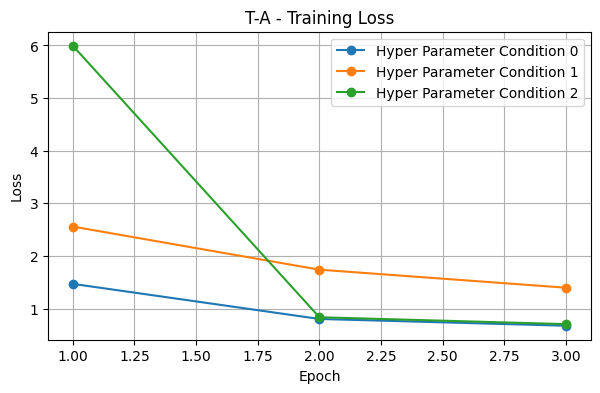

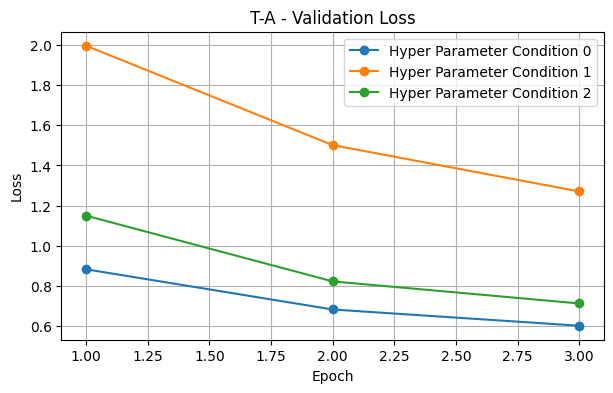

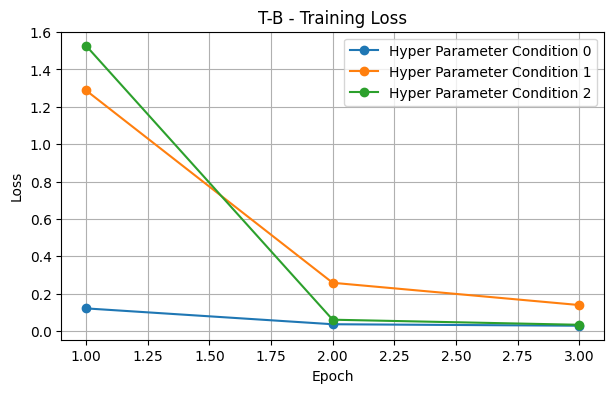

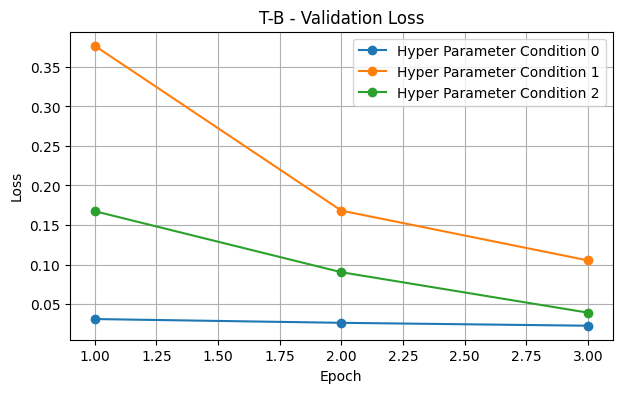

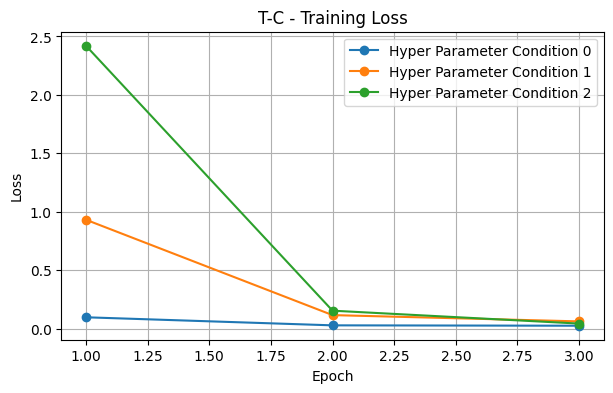

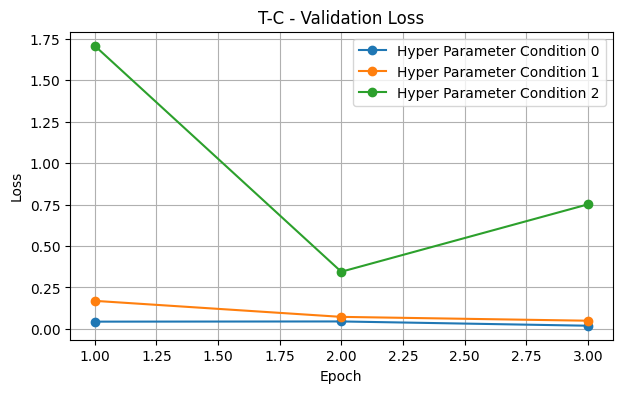

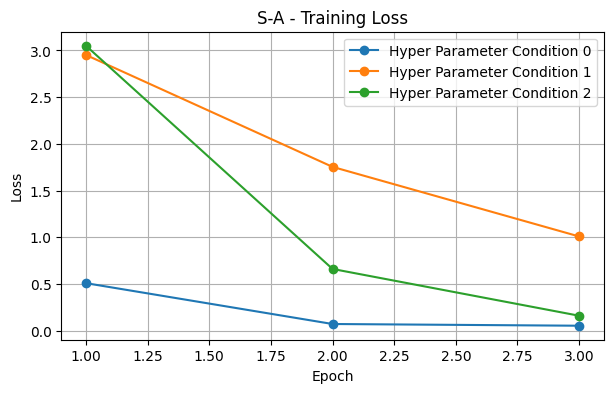

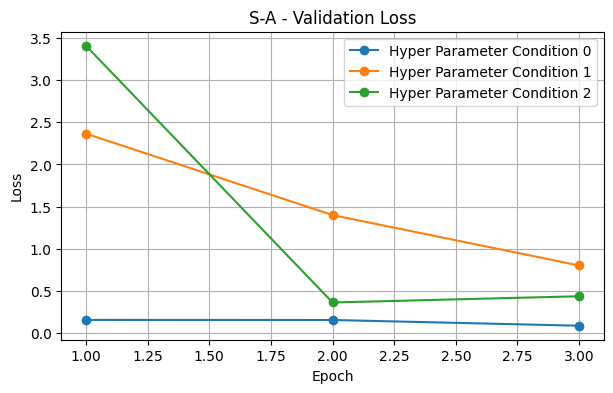

In [ ]:

train_dict = train_combined
val_dict = val_combined

models = ["T-A", "T-B", "T-C", "S-A"]

for model in models:
    train_losses = train_dict[model]
    val_losses = val_dict[model]

    plt.figure(figsize=(7, 4))
    for key, loss_list in train_losses.items():
        plt.plot([1,2,3], loss_list, marker='o', label=f'Hyper Parameter Condition {key}')
    plt.title(f"{model.upper()} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7, 4))
    for key, loss_list in val_losses.items():
        plt.plot([1,2,3],loss_list, marker='o', label=f'Hyper Parameter Condition {key}')
    plt.title(f"{model.upper()} - Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


#Test Set Performance

In [34]:
#Retrain TC model with best paramaters
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

set_requires_grad(model, False)
set_requires_grad(model.fc, True)
set_requires_grad(model.layer4, True)
set_requires_grad(model.layer3, True)

epochs =3
batch_size = 64


train_loader = DataLoader(
train_subset_ds,
batch_size=batch_size,
shuffle=True,
num_workers=2,
pin_memory=True
)

val_loader = DataLoader(
val_subset_ds,
batch_size=batch_size,
shuffle=True,
num_workers=2,
pin_memory=True
)


lr_ = 1e-3
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(trainable_params, lr=lr_)
for epoch in range(1, epochs + 1):
      print(f"\nEpoch {epoch}/{epochs}")

      # Train
      train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)


print('Finished Training')



  ResNet: 11,189,850 parameters FROZEN
  Linear: 13,338 parameters UNFROZEN (trainable)
  Sequential: 8,393,728 parameters UNFROZEN (trainable)
  Sequential: 2,099,712 parameters UNFROZEN (trainable)

Epoch 1/3
    Batch 0/878, Loss: 3.3037
    Batch 100/878, Loss: 0.0207
    Batch 200/878, Loss: 0.0871
    Batch 300/878, Loss: 0.1554
    Batch 400/878, Loss: 0.0154
    Batch 500/878, Loss: 0.0033
    Batch 600/878, Loss: 0.0023
    Batch 700/878, Loss: 0.0060
    Batch 800/878, Loss: 0.0422

Epoch 2/3
    Batch 0/878, Loss: 0.0266
    Batch 100/878, Loss: 0.0097
    Batch 200/878, Loss: 0.0027
    Batch 300/878, Loss: 0.1097
    Batch 400/878, Loss: 0.0229
    Batch 500/878, Loss: 0.0384
    Batch 600/878, Loss: 0.0120
    Batch 700/878, Loss: 0.0448
    Batch 800/878, Loss: 0.0031

Epoch 3/3
    Batch 0/878, Loss: 0.0730
    Batch 100/878, Loss: 0.1312
    Batch 200/878, Loss: 0.0111
    Batch 300/878, Loss: 0.0039
    Batch 400/878, Loss: 0.0087
    Batch 500/878, Loss: 0.1010
    B

In [35]:
#Best Epoch F1 Score

test_loader = DataLoader(
    given_test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

gtest_loss, gtest_acc, true_labels_e, pred_labels_e = evaluate(model, test_loader)

macro_f1 = f1_score(true_labels_e, pred_labels_e,
                  average='macro', labels=list(range(len(full_train_ds.classes))))

#Confustion Matrix
conf_matrix = confusion_matrix(true_labels_e, pred_labels_e,
                              labels=list(range(len(full_train_ds.classes))))

print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
print("\nConfusion Matrix (True vs. Predicted):\n")
print(conf_matrix)

Reached Evaluate
Macro-F1 Score (Best Epoch): 1.0000

Confusion Matrix (True vs. Predicted):

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 

In [36]:
print(gtest_acc)

1.0


#Created Test Set

In [37]:
!cp -r "/content/drive/MyDrive/asl_jpg_test" /content/

In [38]:
class_to_idx = full_train_ds.class_to_idx
created_test_ds = datasets.ImageFolder(root="/content/asl_jpg_test",transform=val_tf)
created_test_ds.class_to_idx = class_to_idx

# Remap samples
created_test_ds.samples = [
    (path, class_to_idx[label_name])
    for (path, label_idx) in created_test_ds.samples
    for label_name in [path.split('/')[-2]]
]
ctest_loader = DataLoader(
    created_test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)



In [39]:
#Best Epoch F1 Score

ctest_loss, ctest_acc, true_labels_e, pred_labels_e = evaluate(model, ctest_loader)

macro_f1 = f1_score(true_labels_e, pred_labels_e,
                  average='macro', labels=list(range(len(full_train_ds.classes))))

#Confustion Matrix
conf_matrix = confusion_matrix(true_labels_e, pred_labels_e,
                              labels=list(range(len(full_train_ds.classes))))

print(f"Macro-F1 Score (Best Epoch): {macro_f1:.4f}")
print("\nConfusion Matrix (True vs. Predicted):\n")
print(conf_matrix)
print()
print(ctest_acc)

Reached Evaluate
Macro-F1 Score (Best Epoch): 0.1392

Confusion Matrix (True vs. Predicted):

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
